This notebook is used to perform basic EDA on the CBECS dataset.

In [855]:
# Import packages
import pandas as pd
import pathlib
import yaml
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import chi2_contingency

Now we'll read in data from both 2018. Because there are so many features in both datasets, and because their schemas aren't exactly the same, I'll start by just importing the 2018 dataset, cleaning it, and exploring feature importances before I bother to wrangle the 2012 dataset.

In [856]:

# Resolve project root from the notebook location
notebook_dir = pathlib.Path().resolve()
config_path = notebook_dir.parent / "conf" / "config.yaml"

# Load config
CFG = yaml.safe_load(open(config_path))

# Point to raw data dir (relative to project root)
RAW_DIR = notebook_dir.parent / CFG["data"]["raw_dir"]

# Pick the 2018 dataset entry from the config
ds_2018 = next(d for d in CFG["datasets"] if d["year"] == 2018)

# Build the path and load
raw_2018 = RAW_DIR / f"cbecs_{ds_2018['year']}_microdata.csv"
if not raw_2018.exists():
    raise FileNotFoundError(f"Missing file: {raw_2018}")

df = pd.read_csv(raw_2018)
print("2018 shape:", df.shape)

2018 shape: (6436, 1249)


Text(0, 0.5, 'Count')

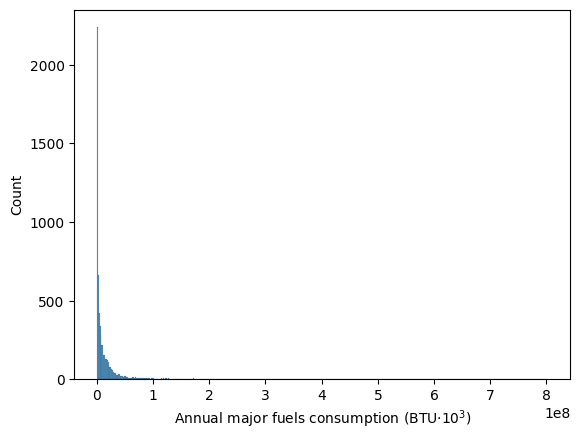

In [857]:
sns.histplot(df["MFBTU"])
plt.xlabel(r"Annual major fuels consumption (BTU$\cdot10^{3}$)")
plt.ylabel("Count")

There are 1249 columns in this dataset. Next step is to trim features that aren't useful.


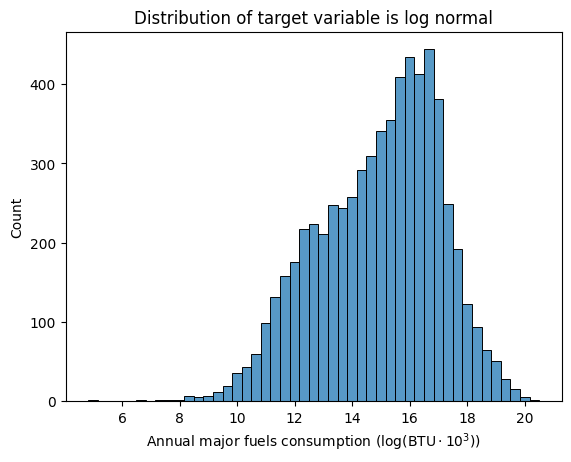

In [858]:
# Clearly the target variable is not normally distributed. Check to see if log-normal.
sns.histplot(np.log(df["MFBTU"]))
plt.xlabel(r"Annual major fuels consumption ($\log(\text{BTU}\cdot10^{3}$))")
plt.ylabel("Count")
plt.title("Distribution of target variable is log normal")
print(f"There are {df.shape[1]} columns in this dataset. Next step is to trim features that aren't useful.")

# Now it's time to clean the dataset and prepare it for some preliminary feature screening

There are 1752 buildings built after 2000 and only 408 missing values.
RENOV     0.063393
RENCOS    0.441734
RENADD    0.441734
RENRDC    0.441734
RENINT    0.441734
RENRFF    0.441734
RENWIN    0.441734
RENHVC    0.441734
RENLGT    0.441734
RENPLB    0.441734
RENELC    0.441734
RENINS    0.441734
RENSAF    0.441734
RENSTR    0.441734
RENOTH    0.441734
dtype: float64
It is True that all missing rows are the same.
Dropped 14 renovation detail columns.


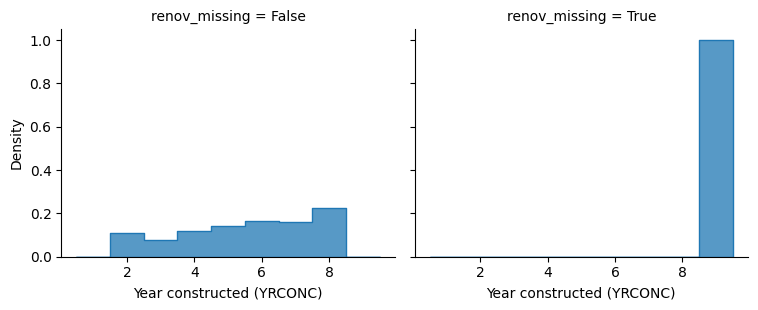

In [859]:
# There is a series of attributes where the question asked is "Was there X type of renovation done before the year 2000?" 
# Need to check and make sure there isn't a pattern in this type of attribute when it's missing.
# I.e. is it possible that all values of NA are jus buildings built after 2000?

buildings_built_after_2000 = np.sum(df.YRCONC == 8) + np.sum(df.YRCONC==9)
missing_renovations = np.sum(df.RENOV.isna())

print(f"There are {buildings_built_after_2000} buildings built after 2000 and only {missing_renovations} missing values.")

plot_df = df.assign(renov_missing=df["RENOV"].isna())
bins = np.arange(0.5, 9.5 + 1, 1)
g = sns.displot(
    data=plot_df,
    x="YRCONC",
    col="renov_missing",
    element="step",
    stat="density",
    common_norm=False,
    height=3.2,
    aspect=1.2,
    bins=bins
)
g.set_axis_labels("Year constructed (YRCONC)", "Density")

# Check if the other RENOV subcategories are related?
# (Trial & error notes)
# I suspected the detailed renovation fields were "weirdly NA", so I started by eyeballing their NA rates one by one…

renov_subs = ["RENCOS","RENADD","RENRDC","RENINT","RENRFF","RENWIN",
              "RENHVC","RENLGT","RENPLB","RENELC","RENINS","RENSAF","RENSTR","RENOTH"]

# 1) Quick peek: are they all missing at about the same rate?
print(df[["RENOV"] + renov_subs].isna().mean().sort_values())

# 2) These sub-items look identical. I'll now confirm that these are all the same missing rows in each column.
base_mask = df[renov_subs[0]].isna()
sanity_check = all((df[c].isna() == base_mask).all() for c in renov_subs)
print(f"It is {sanity_check} that all missing rows are the same.")

# 4) Given this, I’m dropping the detailed subcategories for modeling and keeping higher-level signals only.
df = df.drop(columns=renov_subs)
print(f"Dropped {len(renov_subs)} renovation detail columns.")

# I'll also fill all NA values in RENOV with a 1, since they're new buildings. They'll likely behave more like 
# newly renovated buildings than older buildings which haven't been renovated.
df.loc[:,"RENOV"] = df["RENOV"].fillna(1)

In [860]:

# 0) Create Target Variable
if "MFBTU" in df.columns:
    df = df.dropna(subset=["MFBTU"])
    df = df[df["MFBTU"] > 0]
    df["LOG_MFBTU"] = np.log(df["MFBTU"])

# 1) Identify trivial flag columns (only {0,1,9}) to drop later
def _is_0_1_9_only(s: pd.Series):
    # coerce to numeric (just in case); ignore non-numeric silently
    vals = pd.to_numeric(s, errors="coerce").dropna().unique()
    return len(vals) > 0 and set(vals).issubset({0, 1, 9})

flags_to_remove = [c for c in df.columns if _is_0_1_9_only(df[c])]

# 2) Grouped fillna (batch operations)
cols_0 = ["BASEMNT","NELVTR","NESLTR","DRYCL","RWSEAT","PBSEAT","EDSEAT","FDSEAT","HCBED",
          "RCACP_EL","PKGCP_EL","CHILP_EL","HTPCP_EL","ACWNWP_EL","EVAPP_EL","OTCLP_EL",
          "CHILP_NG","OTCLP_NG","CHILP_FK","OTCLP_FK","CHILP_PR","OTCLP_PR","CHILP_ST","OTCLP_ST",
          "CHWTP_CW","OTCLP_OT","SNACKSF","FASTFDSF","CAFSF","FDPREPSF","XRAYN","RFGRSN","RFGCOMPN",
          "RFGWIN","RFGOPN","RFGCLN","RFGVNN","RFGICN","RFGSTP","PCTERMN","LAPTPN","MLTMON","TABLETN",
          "SERVERN","LGOFFDEVN","SMOFFDEVN","WBOARDSN","TVVIDEON","RGSTRN","ATMN","LTZHRP","LTOHRP",
          "LTNHRP","BULBP","HALOP","HIDP","LEDP","OTLTP","PKLTN","DAYLTP"]
cols_1 = ["RENOV","FACDST","FACDHW","FACDCW","FACELC"]
cols_2 = ["VACANT","DRVTHRU"]

df[list(set(cols_0) & set(df.columns))] = df[list(set(cols_0) & set(df.columns))].fillna(0)
df[list(set(cols_1) & set(df.columns))] = df[list(set(cols_1) & set(df.columns))].fillna(1)
df[list(set(cols_2) & set(df.columns))] = df[list(set(cols_2) & set(df.columns))].fillna(2)

# 3) One-off recodes (guarded)
if "DRVTHRU" in df.columns:
    # "5 = don't know" -> treat as "2 = no"
    df.loc[df["DRVTHRU"] == 5, "DRVTHRU"] = 2

# 4) Top-code handling (cap and add *_TOPCODED indicator) in one pass
TOPCODE_SPECS = {
    "RWSEAT": (99995, 2000),
    "PBSEAT": (99995, 15000),
    "NELVTR": (995, 30),
    "NESLTR": (995, 10),
    "BASEMNT": (995, 5),
    "FLCEILHT": (995, 50),
    "HCBED": (9995, 250),
    "LGOFFDEVN": (9995, 500),
    "SMOFFDEVN": (9995, 500),
    "WBOARDSN": (9995, 200),
    "TVVIDEON": (9995, 200),
}
top_indicators = {}
for col, (sentinel, cutoff) in TOPCODE_SPECS.items():
    if col not in df.columns:
        continue
    # ensure numeric comparison works
    df[col] = pd.to_numeric(df[col], errors="coerce")
    mask = df[col].eq(sentinel)
    top_indicators[f"{col}_TOPCODED"] = mask.astype(int)
    df.loc[mask, col] = cutoff
if top_indicators:
    df = df.assign(**top_indicators)

# 5) NFLOOR: create bins + replace midpoints (guarded)
if "NFLOOR" in df.columns:
    df["NFLOOR_10_14_BIN"] = (df["NFLOOR"] == 994).astype(int)
    df["NFLOOR_TOP_BIN"]  = (df["NFLOOR"] == 995).astype(int)
    df["NFLOOR"] = df["NFLOOR"].replace({994: 12, 995: 15})



# 6) Seat features: make SEATS_TOTAL + SEATS_TOPCODED, then drop parts
seat_parts = [c for c in ["RWSEAT","PBSEAT","EDSEAT","FDSEAT"] if c in df.columns]
top_flags  = [c for c in ["RWSEAT_TOPCODED","PBSEAT_TOPCODED"] if c in df.columns]
assign_seats = {}
if seat_parts:
    assign_seats["SEATS_TOTAL"] = df[seat_parts].sum(axis=1, min_count=1)
if top_flags:
    assign_seats["SEATS_TOPCODED"] = df[top_flags].max(axis=1)
if assign_seats:
    df = df.assign(**assign_seats)
    df = df.drop(columns=[c for c in seat_parts + top_flags if c in df.columns])

# 7) Drop leakage + obvious drops + survey weights + trivial flags in one shot
leakage_risks = [
    "MFEXP","ELBTU","ELCNS","ELEXP","NGBTU","NGCNS","NGEXP",
    "MFHTBTU","MFCLBTU","MFVNBTU","MFWTBTU","MFLTBTU","MFCKBTU",
    "MFRFBTU","MFOFBTU","MFPCBTU","MFOTBTU","ELHTBTU","ELCLBTU",
    "ELVNBTU","ELWTBTU","ELLTBTU","ELCKBTU","ELRFBTU","ELOFBTU",
    "ELPCBTU","ELOTBTU","NGHTBTU","NGCLBTU","NGWTBTU","NGCKBTU","NGOTBTU",
]
obvious_drops = ["SQFTC","ELEVTR","ESCLTR","PUBID","NOCCAT","WKHRSC","NWKERC","LZHRPC","LOHRPC","LNHRPC"]
weights_to_drop = df.filter(regex=r"^FINALWT\d*$").columns.tolist()

drop_cols = set(leakage_risks + obvious_drops + weights_to_drop + flags_to_remove)
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

# 9) Sparsity-based column prune (optional; keep columns where >= (1 - missing_threshold) are non-null)
missing_threshold = 0.9  # drop columns with >90% missing
keep_min = int((1 - missing_threshold) * len(df))
df = df.dropna(axis=1, thresh=keep_min)

# 10) Final defragment for speed
df = df.copy()


# Use a ran


# # Use Variance to remove low-variance features..
# sel = VarianceThreshold(threshold=0.1)  # Can adjust the threshold for near-constant features

# # Apply VarianceThreshold and transform the data
# df_transformed = sel.fit_transform(df)

# # Get the selected column names based on the original DataFrame's columns
# selected_columns = df.columns[sel.get_support()]

# # Create a new DataFrame with the selected columns
# df = pd.DataFrame(df, columns=selected_columns)

# # Check the number of features remaining after pruning
# print(f"Number of features after variance pruning: {df.shape[1]}")


# print(f"Number of features after dropping weights: {df.shape[1]}")





# "FACIL", "FACACT", "PLANT", "BLDPLT", "GOVTYP", "OWNTYPE",
  #  "OWNOCC", "NWNOPR", "WHOPPR", "FKTYPE", "HEATP", "PKGHT", "FURNAC", "SLFCON",
   # "BOILER", "HTPMPH","STHW", "REHEAT","FIREPLC","OTHEQ","PKGHT_EL",





In [869]:
df_with_nans_only

,FEDFAC,FACACT,PLANT,BLDPLT,GOVTYP,OWNOCC,OWNPPR,NWNOPR,WHOPPR,OCCUPYP,FKTYPE,HEATP,PKGHT,FURNAC,SLFCON,BOILER,HTPMPH,STHW,REHEAT,FIREPLC,OTHTEQ,PKGHT_EL,BOILER_EL,HTPMPH_EL,FURNAC_EL,SLFCON_EL,FIREPLC_EL,REHEAT_EL,OTHTEQ_EL,PKGHT_NG,BOILER_NG,HTPMPH_NG,FURNAC_NG,SLFCON_NG,FIREPLC_NG,OTHTEQ_NG,BLRAIR,BLRDUCT,BLRFNCL,BLROTD,BLRRAD,BLRRDFL,BLRWTLP,PKGHPH,HPHPTHP,HPHAIR,HPHGRD,HPHDUAL,HPHWTR,HPHVRF,SPHTPTHP,PKGHP_EL,HTPHP_EL,SLFCNP_EL,FURNP_NG,PKGHP_NG,BOILP_NG,MAINHT,NWMNHT,COOLP,RCAC,PKGCL,CHILLR,HTPMPC,ACWNWL,EVAPCL,OTCLEQ,CHWT,RCAC_EL,PKGCL_EL,CHILLR_EL,HTPMPC_EL,ACWNWL_EL,EVAPCL_EL,OTCLEQ_EL,ACVRF,RMACPTHP,CHLAIR,CHLFNCL,CHLBEAM,CHLWTLP,CHLOTD,CHLAIRCL,CHLWTRCL,CHLABSRP,MAINCL,NWMNCL,EMCS,EMCSHT,EMCSCL,EMCSLT,SMRTTHRM,HWRDHT,HWRDCL,VAV,DOAS,DCV,ECN,MAINT,WTHTEQ,PVC,ENGINE,FUELCL,LRGTRB,MCROTB,OTGENTECH,COGEN,GENUSE,GENGT1MW,ENRGYPLN,SNACK,FASTFD,CAF,FDPREP,KITCHN,BREAKRM,OTFDRM,HWTRM,LAUNDR,MEDEQP,CTSCAN,MRI,LINACC,LABEQP,MCHEQP,POOL,STRLZR,RFGRES,RFGCOMP,RFGWI,RFGOP,RFGCL,RFGVEN,RFGICE,RFGSTO,WHRECOV,PCTERM,LAPTOP,TABLET,SERVER,PCTRMC,LAPTPC,MLTMNC,TABCHRG,SRVUNIT,SERVERC,SRVRCLST,DATACNTR,DCNTRSFC,TRNGRM,STDNRM,LGOFFDEV,SMOFFDEV,WBOARDS,TVVIDEO,RGSTR,LTNR24,LIT,FLUOR,CFLR,BULB,HALO,HID,LED,OTLT,FLUORP,CFLRP,SCHED,OCSN,DIM,DAYHARV,TRIM,PLGCTRL,DRLGHT,PKLTINOUT,TINT,REFL,AWN,SKYLT,FKBTU,FKCNS,FKEXP,FKHTBTU,FKCLBTU,FKWTBTU,FKCKBTU,FKOTBTU
0,NaN,NaN,NaN,NaN,1.0,2.0,1.0,NaN,NaN,100.0,2.0,100.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0,NaN,100.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,NaN,NaN,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,1.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,2.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,NaN,1.0,1.0,2.0,1.0,7.0,5.0,2.0,NaN,1.0,3.0,2.0,1.0,4.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,NaN,1.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,40.0,NaN,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,49435.0,360.0,746.0,0.0,0.0,0.0,0.0,49435.0
1,2.0,4.0,2.0,NaN,NaN,2.0,1.0,NaN,NaN,100.0,NaN,80.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,12.0,1.0,100.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN,2.0,NaN,NaN,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,NaN,1.0,1.0,1.0,1.0,4.0,2.0,3.0,1.0,1.0,1.0,1.0,2.0,NaN,2.0,2.0,1.0,1.0,2.0,1.0,2.0,NaN,1.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,20.0,NaN,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,2.0,1.0,NaN,NaN,100.0,NaN,100.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,2.0,2.0,2.0,1.0,NaN,100.0,NaN,NaN,NaN,NaN,NaN,2.0,1.0,100.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,2.0,2.0,2.0,1.0,NaN,NaN,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,1.0,1.0,1.0,1.0,1.0,2.0,NaN,1.0,1.0,1.0,2.0,2.0,NaN,2.0,2.0,2.0,1.0,2.0,1.0,1.0,NaN,1.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,75.0,20.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,2.0,1.0,NaN,NaN,NaN,NaN,5.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,5.0,NaN,10.0,90.0,11.0,NaN,45.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,N

In [862]:
# from sklearn.ensemble import RandomForestRegressor
# import matplotlib.pyplot as plt


# # Define columns to go into scikit learn
# y = df["LOG_MFBTU"]
# X = df.drop(["MFBTU", "LOG_MFBTU"], axis = 1)

# # Fit Random Forest model
# model = RandomForestRegressor(n_estimators=100, random_state=1)
# model.fit(X, y)  # Assuming X is your feature matrix and y is your target variable


In [863]:
# feature_names = X.columns

# # Get feature importances
# importances = model.feature_importances_

# importance_df = pd.DataFrame({
#     'Feature': feature_names,
#     "Importance": importances
# })

# # Sort the DataFrame by importance in descending order
# importance_df = importance_df.sort_values(by='Importance', ascending=False)

# # Print the top 10 most important features
# print(importance_df.head(10))

# # Plot the feature importances
# plt.figure(figsize=(10, 6))

# # Use iloc to select the top 10 features by position
# plt.barh(importance_df.iloc[:10]['Feature'], importance_df.iloc[:10]['Importance'])

# plt.xlabel('Importance')
# plt.title('Feature Importances from Random Forest')
# plt.show()

In [864]:
# # Now let's drop a bunch of poorly performing features and try again...
# # Define a threshold for feature importance (e.g., 0.01)
# threshold = 0.001

# # Select features with importance above the threshold
# selected_features = importance_df[importance_df['Importance'] > threshold]['Feature']

# # Filter the dataset to keep only the selected features
# X_selected = X[selected_features]

# print(f"Selected features after applying threshold: {selected_features.tolist()}")

# # Fit Random Forest model
# model = RandomForestRegressor(n_estimators=100, random_state=1)
# model.fit(X_selected, y)  # Assuming X is your feature matrix and y is your target variable

# importance_df = pd.DataFrame({
#     'Feature': feature_names,
#     "Importance": importances
# })

# # Sort the DataFrame by importance in descending order
# importance_df = importance_df.sort_values(by='Importance', ascending=False)

# # Print the top 10 most important features
# print(importance_df.head(10))




In [865]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X_selected,y, test_size = 0.8, random_state=1)


# model = RandomForestRegressor(n_estimators=100, random_state=1)
# model.fit(X_train,y_train)



# train_score = model.score(X_train, y_train)
# print(f"R^2 score on training data: {train_score}")
# test_score = model.score(X_test, y_test)
# print(f"R^2 score on test data: {test_score}")





In [866]:
# df["YRCONC"].value_counts()